In [1]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from network import Net
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [4]:
# Global parameters
# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

DATASET_PATH = 'data/EuroSAT_RGB'

BATCH_SIZE = 64 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0005

In [5]:
# Create datasets and data loaders
# Transformations

from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes

print('Dataloaders OK')
test_loader

Dataloaders OK


Image label: 6


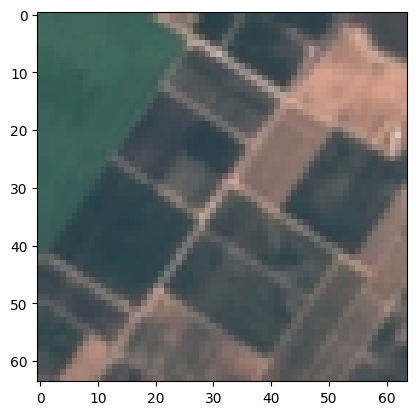

In [6]:
#Print the corresponding label for the image

random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)

In [7]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 4 feature maps is
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(64-3+2(1)/1)+1] = 64 (padding type is same)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        #After max pooling, the output of each feature map is now 64/2 =32
        self.cnn2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        #Output size of each of the 32 feature maps
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #After max pooling, the output of each feature map is 32/2 = 16
        #Flatten the feature maps. You have 8 feature maps, each of them is of size 16x16 --> 8*16*16 = 2048
        self.fc1 = nn.Linear(in_features=8*16*16, out_features=32)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=10)

    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before!
        #It will take the shape (batch_size, 2048)
        out = out.view(x.size(0), -1)

        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        #out = self.droput(out)
        out = self.fc2(out)
        return out

In [8]:
# Create network
model = CNN()
if USE_CUDA:
    model = model.cuda()

print('Network OK')

Network OK


In [9]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Running epoch 1 of 25...


Epoch 1 validation results: Loss=1.0996464652173659 | Accuracy=62.05555725097656



Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.9775298385059132 | Accuracy=63.98147964477539



Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.8934461519998662 | Accuracy=66.94444274902344



Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.8087050541358836 | Accuracy=69.27777862548828



Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.7122746693299097 | Accuracy=74.68518829345703



Running epoch 6 of 25...


Epoch 6 validation results: Loss=0.7791479133946054 | Accuracy=73.5740737915039



Running epoch 7 of 25...


Epoch 7 validation results: Loss=0.8149804557071013 | Accuracy=70.77777862548828



Running epoch 8 of 25...


Epoch 8 validation results: Loss=0.6396089968874173 | Accuracy=76.87036895751953



Running epoch 9 of 25...


Epoch 9 validation results: Loss=0.637117869056323 | Accuracy=76.75926208496094



R

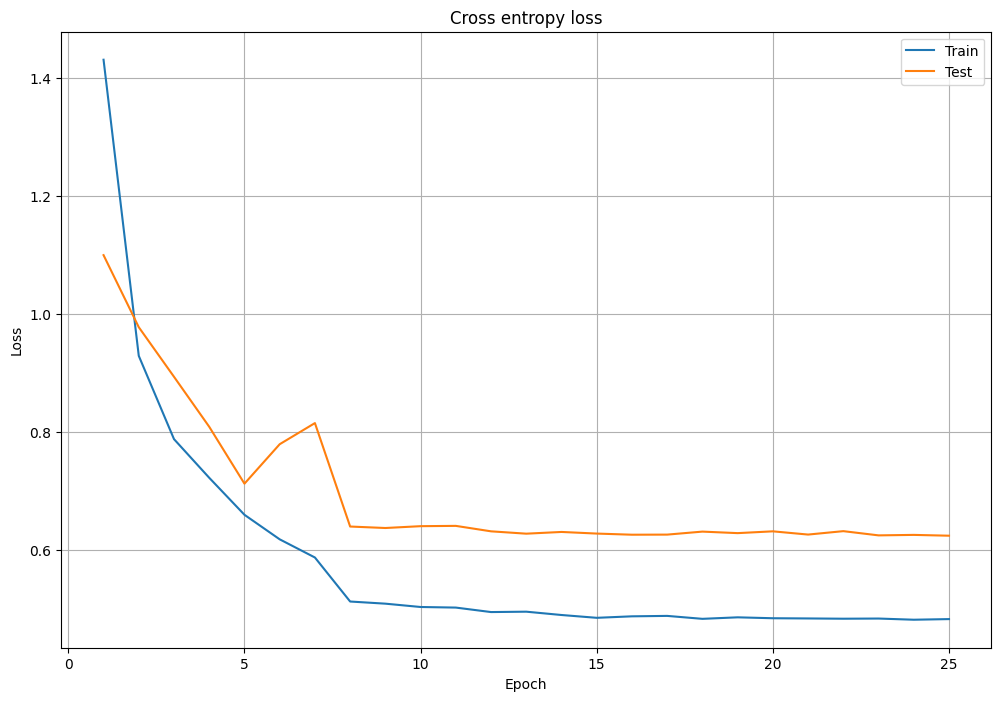

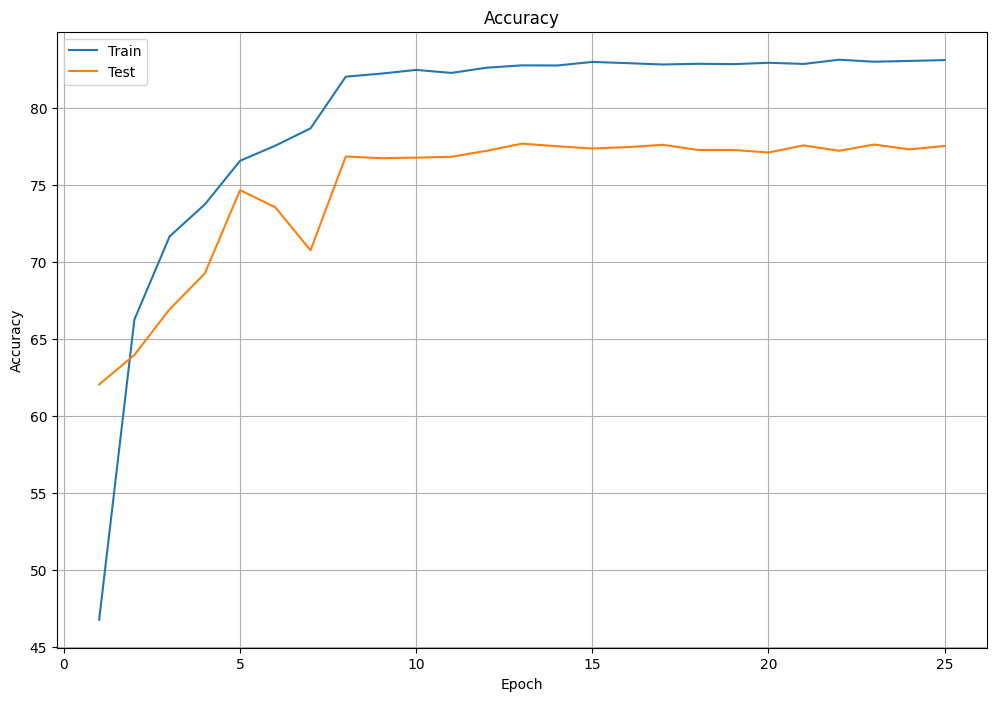

In [10]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------

    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()  # Put the network into training mode

    for i, (inputs, labels) in enumerate(train_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation
        optimizer.step()  # Update the weights

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    scheduler.step()

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))

    #-------------------------Test--------------------------

    correct = 0
    iterations = 0
    testing_loss = 0.0

    model.eval()  # Put the network into evaluation mode

    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))

    print(f'\nEpoch {epoch} validation results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')

    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-cnn.pdf')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-cnn.pdf')

In [12]:
import torch
import torch.nn as nn
from torchsummary import summary

# Create an instance of the CNN model
model = CNN()

# Specify the input size (channels, height, width)
input_size = (3, 64, 64)  # Example input size

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Generate the summary of the model
summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]             112
       BatchNorm2d-2            [-1, 4, 64, 64]               8
              ReLU-3            [-1, 4, 64, 64]               0
         MaxPool2d-4            [-1, 4, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             296
       BatchNorm2d-6            [-1, 8, 32, 32]              16
              ReLU-7            [-1, 8, 32, 32]               0
         MaxPool2d-8            [-1, 8, 16, 16]               0
            Linear-9                   [-1, 32]          65,568
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 66,330
Trainable params: 66,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba